<a href="https://colab.research.google.com/github/Ramzeus-svg/adhd1/blob/main/FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import time

import numpy as np
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io
#import theano
#import theano.tensor as T

from scipy.interpolate import griddata
from sklearn.preprocessing import scale
#from utils import augment_EEG, cart2sph, pol2cart

#import lasagne
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
#from lasagne.layers import Conv2DLayer, MaxPool2DLayer, InputLayer
#from lasagne.layers import DenseLayer, ElemwiseMergeLayer, FlattenLayer
#from lasagne.layers import ConcatLayer, ReshapeLayer, get_output_shape
#from lasagne.layers import Conv1DLayer, DimshuffleLayer, LSTMLayer, SliceLayer


def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)


def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


def build_cnn(input_var=None, w_init=None, n_layers=(4, 2, 1), n_filters_first=32, imsize=32, n_colors=3):
    """
    Builds a VGG style CNN network followed by a fully-connected layer and a softmax layer.
    Stacks are separated by a maxpool layer. Number of kernels in each layer is twice
    the number in previous stack.
    input_var: Theano variable for input to the network
    outputs: pointer to the output of the last layer of network (softmax)
    :param input_var: theano variable as input to the network
    :param w_init: Initial weight values
    :param n_layers: number of layers in each stack. An array of integers with each
                    value corresponding to the number of layers in each stack.
                    (e.g. [4, 2, 1] == 3 stacks with 4, 2, and 1 layers in each.
    :param n_filters_first: number of filters in the first layer
    :param imSize: Size of the image
    :param n_colors: Number of color channels (depth)
    :return: a pointer to the output of last layer
    """
    weights = []        # Keeps the weights for all layers
    count = 0
    # If no initial weight is given, initialize with GlorotUniform
    if w_init is None:
        w_init = [lasagne.init.GlorotUniform()] * sum(n_layers)
    # Input layer
    network = InputLayer(shape=(None, n_colors, imsize, imsize),
                                        input_var=input_var)
    for i, s in enumerate(n_layers):
        for l in range(s):
            network = Conv2DLayer(network, num_filters=n_filters_first * (2 ** i), filter_size=(3, 3),
                          W=w_init[count], pad='same')
            count += 1
            weights.append(network.W)
        network = MaxPool2DLayer(network, pool_size=(2, 2))
    return network, weights


def build_convpool_max(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with maxpooling layer in time.
    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(convnet)
    # convpooling using Max pooling over frames
    convpool = ElemwiseMergeLayer(convnets, theano.tensor.maximum)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = lasagne.layers.DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_conv1d(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with 1D-conv layer to integrate time from sequences of EEG images.
    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    convpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    convpool = Conv1DLayer(convpool, 64, 3)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_lstm(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM layer to integrate time from sequences of EEG images.
    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    convpool = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    # We only need the final prediction, we isolate that quantity and feed it
    # to the next layer.
    convpool = SliceLayer(convpool, -1, 1)      # Selecting the last prediction
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=256, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_mix(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM and 1D-conv layers combined
    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    reformConvpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    conv_out = Conv1DLayer(reformConvpool, 64, 3)
    conv_out = FlattenLayer(conv_out)
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    lstm = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    lstm_out = SliceLayer(lstm, -1, 1)
    # Merge 1D-Conv and LSTM outputs
    dense_input = ConcatLayer([conv_out, lstm_out])
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(dense_input, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    convpool = DenseLayer(convpool,
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Iterates over the samples returing batches of size batchsize.
    :param inputs: input data array. It should be a 4D numpy array for images [n_samples, n_colors, W, H] and 5D numpy
                    array if working with sequence of images [n_timewindows, n_samples, n_colors, W, H].
    :param targets: vector of target labels.
    :param batchsize: Batch size
    :param shuffle: Flag whether to shuffle the samples before iterating or not.
    :return: images and labels for a batch
    """
    if inputs.ndim == 4:
        input_len = inputs.shape[0]
    elif inputs.ndim == 5:
        input_len = inputs.shape[1]
    assert input_len == len(targets)
    if shuffle:
        indices = np.arange(input_len)
        np.random.shuffle(indices)
    for start_idx in range(0, input_len, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if inputs.ndim == 4:
            yield inputs[excerpt], targets[excerpt]
        elif inputs.ndim == 5:
            yield inputs[:, excerpt], targets[excerpt]


def train(images, labels, fold, model_type, batch_size=32, num_epochs=5):
    """
    A sample training function which loops over the training set and evaluates the network
    on the validation set after each epoch. Evaluates the network on the training set
    whenever the
    :param images: input images
    :param labels: target labels
    :param fold: tuple of (train, test) index numbers
    :param model_type: model type ('cnn', '1dconv', 'maxpool', 'lstm', 'mix')
    :param batch_size: batch size for training
    :param num_epochs: number of epochs of dataset to go over for training
    :return: none
    """
    num_classes = len(np.unique(labels))
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = reformatInput(images, labels, fold)
    X_train = X_train.astype("float32", casting='unsafe')
    X_val = X_val.astype("float32", casting='unsafe')
    X_test = X_test.astype("float32", casting='unsafe')
    # Prepare Theano variables for inputs and targets
    input_var = T.TensorType('floatX', ((False,) * 5))()
    target_var = T.ivector('targets')
    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    # Building the appropriate model
    if model_type == '1dconv':
        network = build_convpool_conv1d(input_var, num_classes)
    elif model_type == 'maxpool':
        network = build_convpool_max(input_var, num_classes)
    elif model_type == 'lstm':
        network = build_convpool_lstm(input_var, num_classes, 100)
    elif model_type == 'mix':
        network = build_convpool_mix(input_var, num_classes, 100)
    elif model_type == 'cnn':
        input_var = T.tensor4('inputs')
        network, _ = build_cnn(input_var)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=256,
                             nonlinearity=lasagne.nonlinearities.rectify)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=num_classes,
                             nonlinearity=lasagne.nonlinearities.softmax)
    else:
        raise ValueError("Model not supported ['1dconv', 'maxpool', 'lstm', 'mix', 'cnn']")
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adam(loss, params, learning_rate=0.001)
    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    # Finally, launch the training loop.
    print("Starting training...")
    best_validation_accu = 0
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=False):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
        av_train_err = train_err / train_batches
        av_val_err = val_err / val_batches
        av_val_acc = val_acc / val_batches
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(av_train_err))
        print("  validation loss:\t\t{:.6f}".format(av_val_err))
        print("  validation accuracy:\t\t{:.2f} %".format(av_val_acc * 100))
        if av_val_acc > best_validation_accu:
            best_validation_accu = av_val_acc
            # After training, we compute and print the test error:
            test_err = 0
            test_acc = 0
            test_batches = 0
            for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
                inputs, targets = batch
                err, acc = val_fn(inputs, targets)
                test_err += err
                test_acc += acc
                test_batches += 1
            av_test_err = test_err / test_batches
            av_test_acc = test_acc / test_batches
            print("Final results:")
            print("  test loss:\t\t\t{:.6f}".format(av_test_err))
            print("  test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))
            # Dump the network weights to a file like this:
            np.savez('weights_lasg_{0}'.format(model_type), *lasagne.layers.get_all_param_values(network))
    print('-'*50)
    print("Best validation accuracy:\t\t{:.2f} %".format(best_validation_accu * 100))
    print("Best test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))

'''
if __name__ == '__main__':
    from utils import reformatInput
    # Load electrode locations
    print('Loading data...')
    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')
    locs_3d = locs['A']
    locs_2d = []
    # Convert to 2D
    for e in locs_3d:
        locs_2d.append(azim_proj(e))
    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']
    print ('Feats Shape: ',feats.shape)
    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])
    # Leave-Subject-Out cross validation
    fold_pairs = []
    for i in np.unique(subj_nums):
        ts = subj_nums == i
        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))
        ts = np.squeeze(np.nonzero(ts))
        np.random.shuffle(tr)  # Shuffle indices
        np.random.shuffle(ts)
        fold_pairs.append((tr, ts))
    # CNN Mode
    print('Generating images...')
    # Find the average response over time windows
    av_feats = reduce(lambda x, y: x+y, [feats[:, i*192:(i+1)*192] for i in range(feats.shape[1] / 192)])
    av_feats = av_feats / (feats.shape[1] / 192)
    images = gen_images(np.array(locs_2d),
                                  av_feats,
                                  32, normalize=False)
    print('\n')
    # Class labels should start from 0
    print('Training the CNN Model...')
    train(images, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'cnn')
    # Conv-LSTM Mode
    print('Generating images for all time windows...')
    images_timewin = np.array([gen_images(np.array(locs_2d),
                                                    feats[:, i * 192:(i + 1) * 192], 32, normalize=False) for i in
                                         range(feats.shape[1] / 192)
                                         ])
    print('\n')
    print('Training the LSTM-CONV Model...')
    train(images_timewin, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'mix')
    print('Done!')
'''

"\nif __name__ == '__main__':\n    from utils import reformatInput\n    # Load electrode locations\n    print('Loading data...')\n    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')\n    locs_3d = locs['A']\n    locs_2d = []\n    # Convert to 2D\n    for e in locs_3d:\n        locs_2d.append(azim_proj(e))\n    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']\n    print ('Feats Shape: ',feats.shape)\n    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])\n    # Leave-Subject-Out cross validation\n    fold_pairs = []\n    for i in np.unique(subj_nums):\n        ts = subj_nums == i\n        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))\n        ts = np.squeeze(np.nonzero(ts))\n        np.random.shuffle(tr)  # Shuffle indices\n        np.random.shuffle(ts)\n        fold_pairs.append((tr, ts))\n    # CNN Mode\n    print('Generating images...')\n    # Find the average response over time windows\n    av_

In [ ]:
import keras
print(keras.__version__)

2.8.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [4]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [5]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [6]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [7]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [8]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [9]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [10]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [11]:
file_names = ['drive/MyDrive/newdata/ML101_KS.csv',
              'drive/MyDrive/newdata/ML101_US.csv',
              'drive/MyDrive/newdata/ML102_KS.csv',
              'drive/MyDrive/newdata/ML102_US.csv',
              'drive/MyDrive/newdata/ML103_KS.csv',
              'drive/MyDrive/newdata/ML103_US.csv',
              'drive/MyDrive/newdata/ML104_KS.csv',
              'drive/MyDrive/newdata/ML104_US.csv',
              'drive/MyDrive/newdata/ML105_KS.csv',
              'drive/MyDrive/newdata/ML105_US.csv',
              'drive/MyDrive/newdata/ML106_KS.csv',
              'drive/MyDrive/newdata/ML106_US.csv',
              'drive/MyDrive/newdata/ML107_KS.csv',
              'drive/MyDrive/newdata/ML107_US.csv',
              'drive/MyDrive/newdata/ML108_KS.csv',
              'drive/MyDrive/newdata/ML108_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)


Generating training data...
Processing session:  drive/MyDrive/newdata/ML101_KS.csv . ( 1  of  16 )
234  frames generated with label  1 .


Processing session:  drive/MyDrive/newdata/ML101_US.csv . ( 2  of  16 )
224  frames generated with label  0 .


Processing session:  drive/MyDrive/newdata/ML102_KS.csv . ( 3  of  16 )
222  frames generated with label  1 .


Processing session:  drive/MyDrive/newdata/ML102_US.csv . ( 4  of  16 )
218  frames generated with label  0 .


Processing session:  drive/MyDrive/newdata/ML103_KS.csv . ( 5  of  16 )
226  frames generated with label  1 .


Processing session:  drive/MyDrive/newdata/ML103_US.csv . ( 6  of  16 )
208  frames generated with label  0 .


Processing session:  drive/MyDrive/newdata/ML104_KS.csv . ( 7  of  16 )
202  frames generated with label  1 .


Processing session:  drive/MyDrive/newdata/ML104_US.csv . ( 8  of  16 )
204  frames generated with label  0 .


Processing session:  drive/MyDrive/newdata/ML105_KS.csv . ( 9  of  16 )
214 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
X.shape

(3642, 28, 28, 3)

In [13]:
y.shape

(3642,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


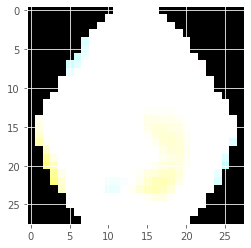

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [16]:
y_train.shape

(2913,)

In [17]:
x_train.shape

(2913, 28, 28, 3)

In [18]:
x_test.shape


(729, 28, 28, 3)

In [19]:
y_test.shape

(729,)

In [20]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape, 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (2913, 28, 28, 3)
2913 train samples
(729, 28, 28, 3) test samples


In [ ]:
!pip install q keras==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/200
92/92 [==============================] - 8s 73ms/step - loss: 0.6953 - accuracy: 0.5005 - val_loss: 0.6912 - val_accuracy: 0.5158
Epoch 2/200
92/92 [==============================] - 6s 70ms/step - loss: 0.6853 - accuracy: 0.5307 - val_loss: 0.7138 - val_accuracy: 0.5226
Epoch 3/200
92/92 [==============================] - 6s 71ms/step - loss: 0.6771 - accuracy: 0.5424 - val_loss: 0.6870 - val_accuracy: 0.5158
Epoch 4/200
92/92 [==============================] - 6s 70ms/step - loss: 0.6648 - accuracy: 0.5716 - val_loss: 0.6638 - val_accuracy: 0.5967
Epoch 5/200
92/92 [==============================] - 6s 70ms/step - loss: 0.6605 - accuracy: 0.5826 - val_loss: 0.6599 - val_accuracy: 0.6049
Epoch 6/200
92/92 [==============================] - 6s 71ms/step - loss: 0.6548 - accuracy: 0.5915 - val_loss: 0.6617 - val_accuracy: 0.5953
Epoch 7/200
92/92 [==============================] - 6s 70ms/step - loss: 0.6480 - accuracy: 0.6025 - val_loss: 0.6563 - val_accuracy: 0.5816
Epoch 